In [1]:
import os
os.chdir("../../quantum_eigenfaces/package/")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Load data

In [3]:
from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig
from quantum_eigenfaces.quantum_model import QuantumModel
from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces import CROPPED_YALE_DATASET_PATH
from quantum_eigenfaces.utils.yale import compute_yale_X_and_y

In [4]:
from quantum_eigenfaces.utils.yale import compute_yale_face_dataset_from_files
df = compute_yale_face_dataset_from_files(dataset_folder_path=CROPPED_YALE_DATASET_PATH)
print(f"dataset's shape: {df.shape}")
df.head()

dataset's shape: (2414, 4)


,img,subject,A,E
0,"[2, 2, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 3, 3, 2, ...",33,-050,-40
1,"[7, 7, 6, 3, 4, 3, 4, 3, 4, 3, 2, 4, 3, 4, 3, ...",33,+000,+90
2,"[153, 148, 147, 143, 144, 147, 150, 143, 139, ...",33,+085,-20
3,"[2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, ...",33,-070,+00
4,"[108, 114, 113, 113, 115, 112, 115, 114, 114, ...",33,+035,-20


In [5]:
sorted(df["E"].unique())

['+00',
 '+10',
 '+15',
 '+20',
 '+40',
 '+45',
 '+65',
 '+90',
 '-10',
 '-20',
 '-35',
 '-40']

In [6]:
sorted(df["E"].unique())

['+00',
 '+10',
 '+15',
 '+20',
 '+40',
 '+45',
 '+65',
 '+90',
 '-10',
 '-20',
 '-35',
 '-40']

## Split data

In [7]:
A_to_keep = ['+000',
             '+020', 
             '-025',  
             '+005',
             '+010', 
             '-015', 
             '-020', 
             '-010', 
             '+015', 
             '-005' 
             '+025'
            ]

E_to_keep = ['+00',
             '+10',
             '+15',
             '+20',
             '-10',
             '-20']

df_ = df[df["A"].isin(A_to_keep) & df["E"].isin(E_to_keep)]
df_.shape

anomalies_in_test = ['36', '37', '38', '39']
anomalies_in_valid = ['31', '32', '33', '34', '35']
subjects_shared = (set(df["subject"].unique()) - set(anomalies_in_test)) - set(anomalies_in_valid)
print("subjects shared: ", subjects_shared)
from sklearn.model_selection import train_test_split
df_shared = df_[df_["subject"].isin(subjects_shared)]
X_shared, y_shared = compute_yale_X_and_y(df_shared)

train_val_test = [0.70,0.15,0.15]
X_train, X_test, y_train, y_test = train_test_split(X_shared, y_shared, test_size=train_val_test[2], random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)

# concatenate anomalies to shared subjects
df_valid_anomalies = df_[df_["subject"].isin(anomalies_in_valid)]
X_valid_anomalies, y_valid_anomalies = compute_yale_X_and_y(df_valid_anomalies)
n_valid_anomalies = X_valid_anomalies.shape[0]
X_valid_wa = np.concatenate((X_val, X_valid_anomalies), axis=0)
y_valid_wa = np.concatenate((y_val, y_valid_anomalies), axis=0)
print(f"percentage of outliers in validation set: {n_valid_anomalies/X_valid_wa.shape[0]}")

df_test_anomalies = df_[df_["subject"].isin(anomalies_in_test)]
X_test_anomalies, y_test_anomalies = compute_yale_X_and_y(df_test_anomalies)
n_test_anomalies = X_test_anomalies.shape[0]
X_test_wa = np.concatenate((X_test, X_test_anomalies), axis=0)
y_test_wa = np.concatenate((y_test, y_test_anomalies), axis=0)
print(f"percentage of outliers in test set: {n_test_anomalies/X_test_wa.shape[0]}")

subjects shared:  {'29', '08', '02', '21', '04', '05', '03', '16', '26', '30', '07', '17', '13', '10', '23', '15', '24', '09', '20', '18', '06', '12', '27', '19', '11', '01', '28', '22', '25'}
percentage of outliers in validation set: 0.5369127516778524
percentage of outliers in test set: 0.47761194029850745


### Normalize data

In [8]:
X_train_n = X_train / 255
X_valid_na_n = X_val / 255
X_valid_wa_n = X_valid_wa / 255
X_test_na_n = X_test / 255
X_test_wa_n = X_test_wa / 255

In [9]:

print(f"X_train_n:    {X_train_n.shape}")
print(f"y_train:      {y_train.shape}")
print("------------------------")
print(f"X_valid_na_n: {X_valid_na_n.shape}")
print(f"y_valid_na:   {y_val.shape}")
print(f"X_valid_wa_n: {X_valid_wa_n.shape}")
print(f"y_valid_wa:   {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_na:    {X_test_na_n.shape}")
print(f"y_test_na:    {y_test.shape}")
print(f"X_test_wa_n:  {X_test_wa_n.shape}")
print(f"y_test_wa:    {y_test_wa.shape}")

X_train_n:    (322, 32256)
y_train:      (322,)
------------------------
X_valid_na_n: (69, 32256)
y_valid_na:   (69,)
X_valid_wa_n: (149, 32256)
y_valid_wa:   (149,)
------------------------
X_test_na:    (70, 32256)
y_test_na:    (70,)
X_test_wa_n:  (134, 32256)
y_test_wa:    (134,)


In [10]:

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

datasplit_without_outliers = DataSplit(X_train=X_train_n,
                                       y_train=y_train,
                                       X_valid=X_valid_na_n,
                                       y_valid=y_val,
                                       X_test=X_test_na_n,
                                       y_test=y_test)

training_config = TrainingConfig(n_components=80)
tuning_config = TuningConfig(tot_num_of_deltas=3200)
reshaper = (192,168)

# Classical Experiments 

### $\delta_1= \infty$;  Norm Threshold = False; Outliers = False 

In [11]:
from quantum_eigenfaces.utils.visualization import plot_metrics_at_varying_epsilon
np.random.seed(0)

epsilons_domain = [0]
xi = 0

summary1 = epsilon_tuning(datasplit=datasplit_without_outliers, 
               training_config=training_config, 
               tuning_config=tuning_config,
               reshaper=reshaper,
               epsilons=epsilons_domain,
               use_norm_threshold=False,
               num_iterations=1,
               delta1=10000,
               xi=xi) 

********* TRAINING **************
Normalization Threshold is: 0.940198
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.9857142857142858
Avg Accuracy Train: 0.9857142857142858
Avg Recall: 0.0


In [12]:
summary1

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.985714,0.985714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = False; Outliers = True 

********* TRAINING **************
Normalization Threshold is: 0.940198
********* TUNING **************
Min delta:  44.72903383093215 ; Max delta:  736.7838737060547


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 3370.50it/s]


Chosen delta1: 232.01637487213594


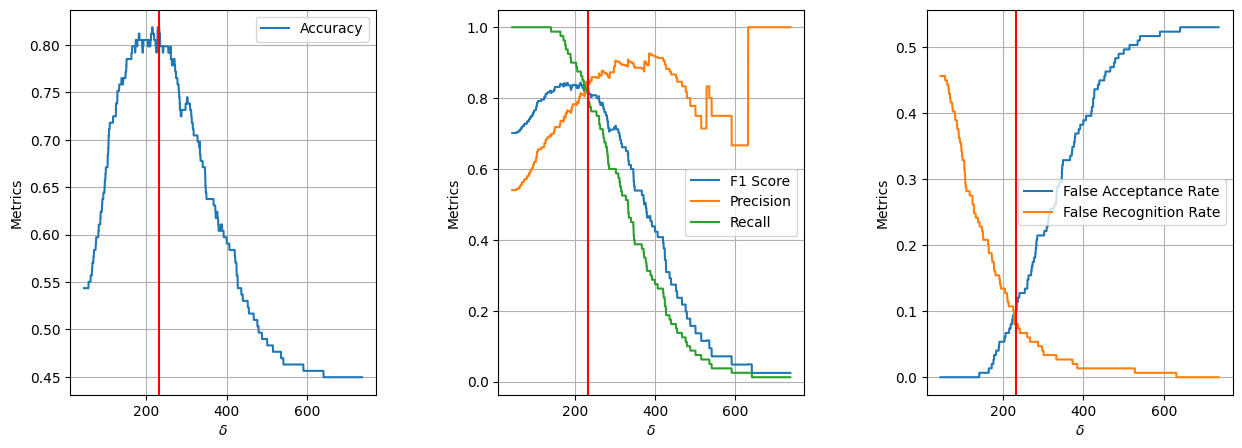

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0
Compute predictions...
The norm threshold is not going to be used.
********* TESTING **************


Avg Accuracy: 0.8880597014925373
Avg Accuracy Train: 0.9
Avg Recall: 0.875


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

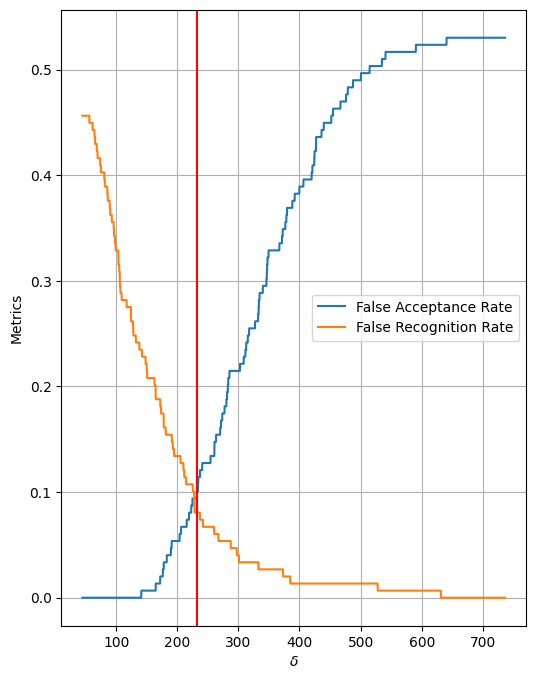

In [13]:
np.random.seed(0)

epsilons_domain = [0]
xi = 0

summary2 = epsilon_tuning(datasplit=datasplit_with_outliers, 
               training_config=training_config, 
               tuning_config=tuning_config,
               reshaper=(192,168),
               epsilons=epsilons_domain,
               use_norm_threshold=False,
               num_iterations=1,
               visuals=False,
               xi=xi)



In [14]:
summary2

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.88806,0.9,0.059701,0.044776,0.903226,0.875,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True 

********* TRAINING **************
Normalization Threshold is: 0.940198
********* TUNING **************
Min delta:  44.72903383093215 ; Max delta:  736.7838737060547


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 3438.96it/s]


Chosen delta1: 232.01637487213594


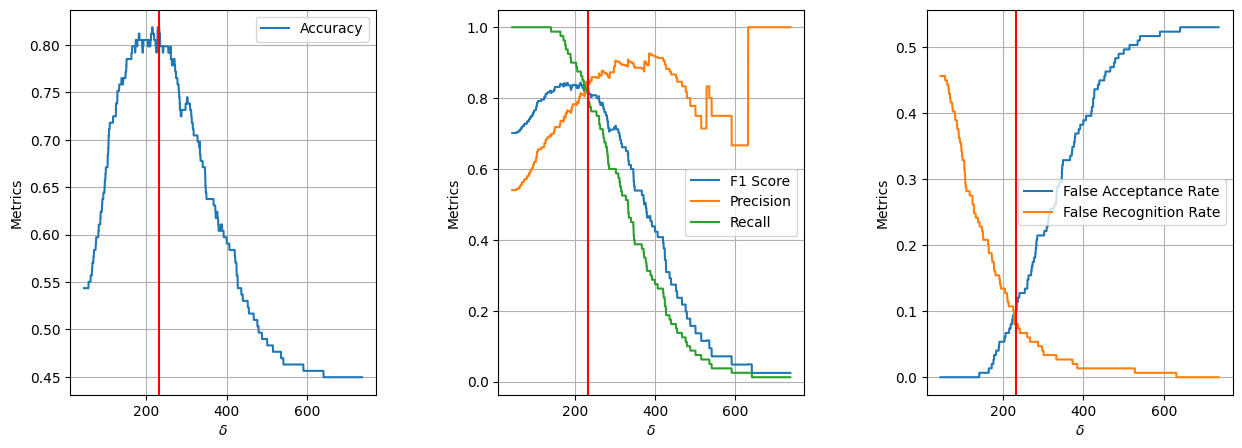

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9402985074626866
Avg Accuracy Train: 0.9
Avg Recall: 0.984375


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

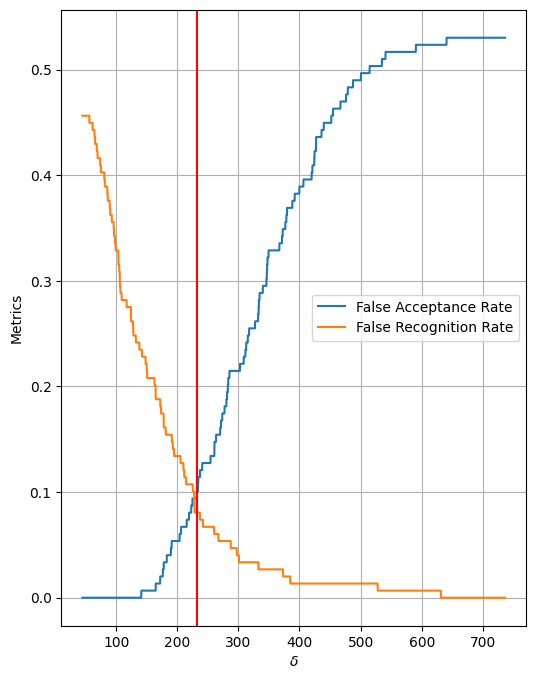

In [15]:
np.random.seed(0)

epsilons_domain = [0]
xi = 0.01


summary3 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                          training_config=training_config, 
                          tuning_config=tuning_config,
                          reshaper=reshaper,
                          epsilons=epsilons_domain,
                          use_norm_threshold=True,
                          num_iterations=1,
                          visuals=False,
                          ds_name="Yale",
                          compute_runtimes=False,
                          xi=xi)

In [16]:
summary3

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.940299,0.9,0.007463,0.044776,0.913043,0.984375,0.947368,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Quantum Algorithm

### $\delta_1= tuned$;  Norm Threshold = True; Outliers = True 

********* TRAINING **************
Normalization Threshold is: 0.940198
********* TUNING **************
Min delta:  44.72903383093215 ; Max delta:  736.7838737060547


tuning delta1...: 100%|███████████████████| 3200/3200 [00:00<00:00, 3390.39it/s]


Chosen delta1: 232.01637487213594


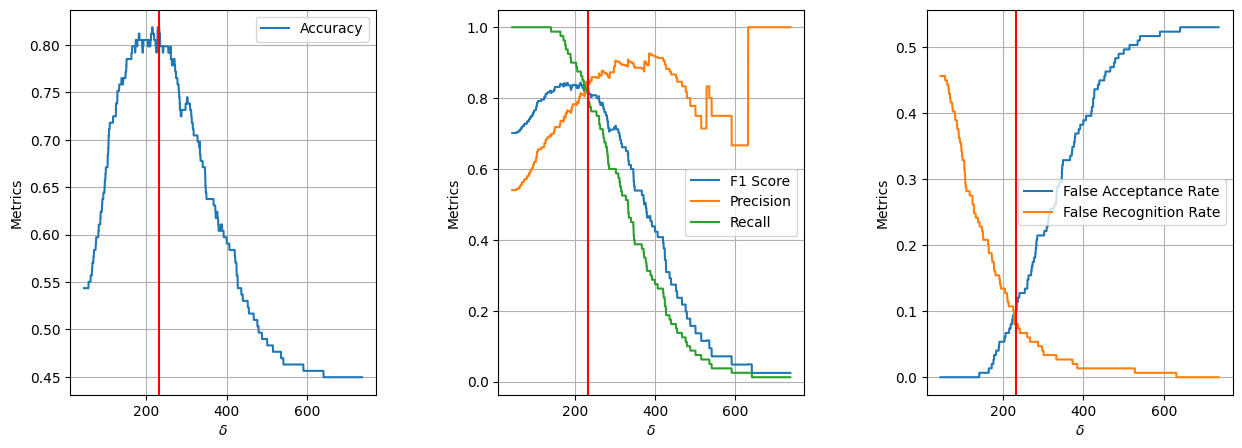

Saved plot at DELTA_acc.pdf
Saved plot at DELTA_pre_rec_and_f1.pdf
Saved plot at DELTA_far_and_frr.pdf
_______
Epsilon: 0
Computing runtimes...
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9286567164179106
Avg Accuracy Train: 0.8909047619047622
Avg Recall: 0.9699479166666667
_______
Epsilon: 50
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 50
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.921592039800995
Avg Accuracy Train: 0.8798095238095239
Avg Recall: 0.9672916666666667
_______
Epsilon: 100
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 100
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9103731343283581
Avg Accuracy Train: 0.8655714285714285
Avg Recall: 0.959375
_______
Epsilon: 150
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 150
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8947014925373136
Avg Accuracy Train: 0.8432380952380952
Avg Recall: 0.9509895833333334
_______
Epsilon: 200
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 200
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8857711442786069
Avg Accuracy Train: 0.8306190476190475
Avg Recall: 0.94609375
_______
Epsilon: 250
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 250
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8810696517412934
Avg Accuracy Train: 0.8269999999999998
Avg Recall: 0.9402083333333333
_______
Epsilon: 300
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 300
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8776119402985074
Avg Accuracy Train: 0.8193809523809523
Avg Recall: 0.9413020833333333
_______
Epsilon: 350
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 350
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8704228855721393
Avg Accuracy Train: 0.8074285714285714
Avg Recall: 0.9393229166666667
_______
Epsilon: 400
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 400
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8629353233830844
Avg Accuracy Train: 0.7941428571428572
Avg Recall: 0.9381770833333334
_______
Epsilon: 450
Computing runtimes...
sqrt p: 17.944358444926362
mu: 8.944271909998994
max_c_train_norm: 66.13029204654516
avg U_bar_norms: 26.745260210216603
epsilon: 450
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8534577114427859
Avg Accuracy Train: 0.7765238095238094
Avg Recall: 0.9376041666666667


<Figure size 640x480 with 0 Axes>

<Figure size 600x800 with 0 Axes>

<Figure size 600x800 with 0 Axes>

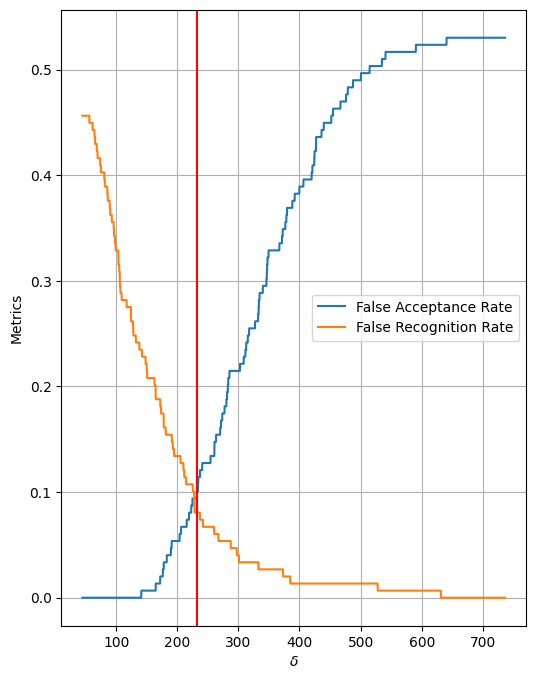

In [17]:
np.random.seed(0)

epsilons_domain = np.arange(0, 500, 50)
xi = 0.01


summary4, rts4 = epsilon_tuning(datasplit=datasplit_with_outliers, 
                                training_config=training_config, 
                                tuning_config=tuning_config,
                                reshaper=(192,168),
                                epsilons=epsilons_domain,
                                use_norm_threshold=True,
                                num_iterations=300,
                                visuals=False,
                                ds_name="Yale",
                                compute_runtimes=True,
                                xi=xi)

In [18]:
summary4.head()

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.928657,0.890905,0.014353,0.049527,0.903442,0.969948,0.935479,0.006920,0.006871,0.005572,0.003589,0.006534,0.011666,0.007182
1,50,0.921592,0.879810,0.015622,0.055448,0.893120,0.967292,0.928615,0.011807,0.019808,0.006323,0.009356,0.016198,0.013239,0.011014
2,100,0.910373,0.865571,0.019403,0.059726,0.885143,0.959375,0.920585,0.016726,0.026529,0.008465,0.012480,0.021602,0.017724,0.015350
3,150,0.894701,0.843238,0.023408,0.067040,0.872227,0.950990,0.909610,0.018418,0.032907,0.008100,0.016103,0.026731,0.016959,0.016189
4,200,0.885771,0.830619,0.025746,0.069353,0.867951,0.946094,0.904981,0.021159,0.037351,0.009142,0.017766,0.029521,0.019142,0.018131


Saved plot at YALE_epsilon_wrt_acc_train_and_recall.pdf
Saved plot at YALE_epsilon_wrt_acc_train_and_recall.pdf


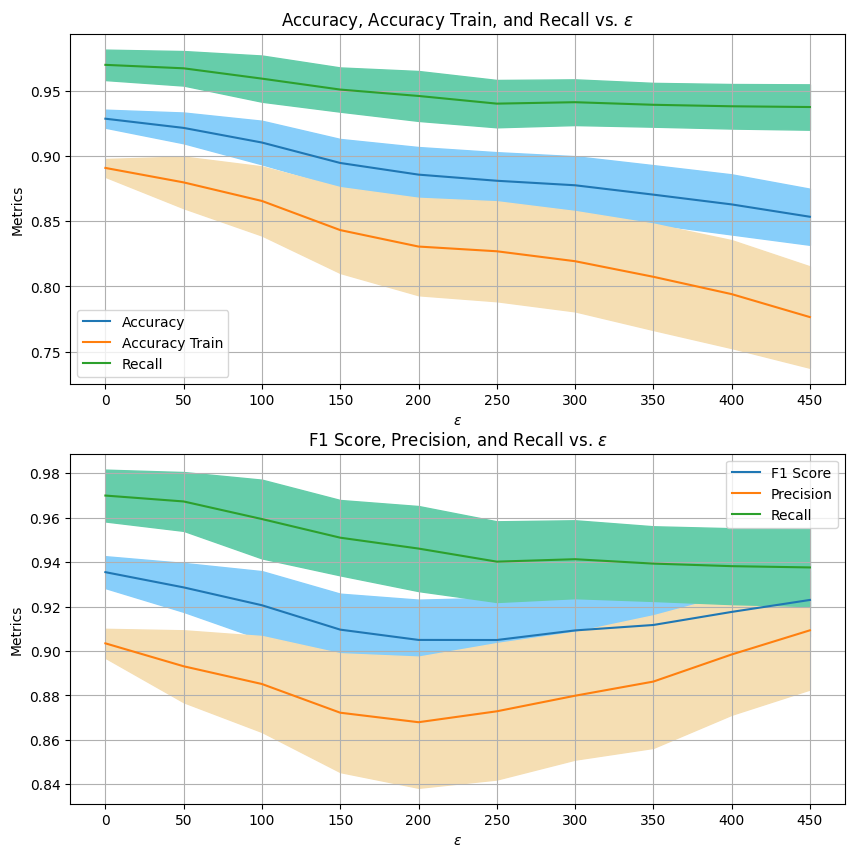

In [19]:
plot_metrics_at_varying_epsilon(summary4, "YALE", epsilon_domain=epsilons_domain)

In [20]:
from quantum_eigenfaces.utils.runtime import find_highest_acceptable_epsilon

highest_acceptable_epsilon = find_highest_acceptable_epsilon(summary4)
print("highest acceptable epsilon: ", highest_acceptable_epsilon)

0.9286567164179106
0.9054402985074628
highest acceptable epsilon:  100


In [21]:
rts4.head()

,epsilon,classical runtime,average runtime,stddev runtime
0,0,2606240,-1.000000,0.000000
1,50,2606240,5677.409149,1110.158723
2,100,2606240,2838.704574,555.079362
3,150,2606240,1892.469716,370.052908
4,200,2606240,1419.352287,277.539681


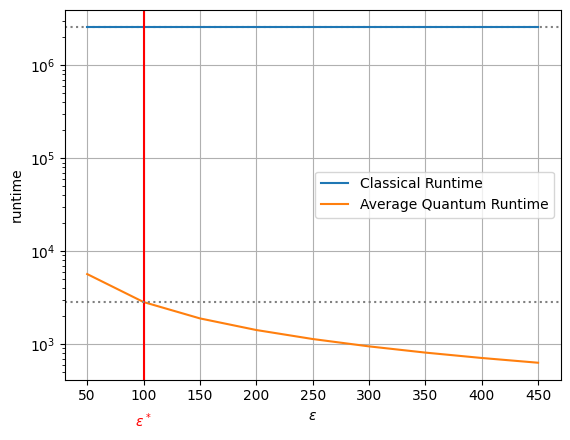

In [22]:
def plot_quantum_vs_classical(rts, highest_acceptable_epsilon):
    x_padding = -65
    
    
    # Classical runtime
    crt = rts["classical runtime"].values[0]
    plt.axhline(crt, linestyle=":", c="grey")
    plt.plot(rts["epsilon"], rts["classical runtime"], label="Classical Runtime")
    
    # Quantum runtime
    plt.plot(rts["epsilon"], rts["average runtime"], label="Average Quantum Runtime")
    plt.xlabel("$\epsilon$")
    plt.ylabel("runtime")

    
    plt.yscale('log')

    plt.axvline(x=highest_acceptable_epsilon, c="red")

    plt.text(highest_acceptable_epsilon, 150, r'$\epsilon^*$', ha='center', va='center', c="red")
    
    y = rts[rts["epsilon"] == highest_acceptable_epsilon]["average runtime"].values[0]
    plt.axhline(y, linestyle=":", c="grey")


    plt.grid(True)
    plt.legend()
    plt.savefig("YALE_quantum_runtime.pdf")

    
    
plot_quantum_vs_classical(rts4[1:], highest_acceptable_epsilon)